In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

### Movie 3

door bbox: 'x': 271, 'y': 6, 'width': 437, 'height': 688

golf bbox: 'x': 325, 'y': 364, 'width': 187, 'height': 330

# Approach 1
1. Calculate the overlap of contour boxes of door with the bounding box of golf stick
2. Take the box with maximum overlap with golf stick box and calculate the angle of the left edge of the box with the vertical edge of the image 
3. if no overlap is found, find the contour bbox closest to golf bbox and calculate its angle with the vertical axis of the image

### Golf stick bbox

In [2]:
# bbox of golf stick 
top_left_x = 325  # X coordinate of the top left corner
top_left_y = 364  # Y coordinate of the top left corner
crop_width = 187  # Width of the crop region
crop_height = 330  # Height of the crop region

### Contour bboxes of Door

In [3]:
# make sure the contour bboxes are calculated on full scale image 
sam_mask = np.load('images/movie_3/movie_3_door_mask.npy')
print(sam_mask.shape)

boolean_mask = sam_mask[0]
boolean_mask.shape

(3, 960, 720)


(960, 720)

In [4]:
# Convert boolean mask to an 8-bit unsigned integer mask
int_mask = (boolean_mask * 255).astype(np.uint8)

# Convert the mask to a BGR image
bgr_mask = cv2.merge([int_mask, int_mask, int_mask])

# Convert the mask to grayscale
imgray = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image
ret, thresh = cv2.threshold(imgray, 127, 255, 0)

In [5]:
# Step 1: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ensure there are contours found
if len(contours) == 0:
    raise ValueError("No contours found in the mask.")

In [6]:
# there is only one contour, cool 
len(contours)

4

In [7]:
# Step 2: Calculate the minimum area bounding rectangles for each contour
# each min area rect is of the following format (center (x, y), (width, height), angle of rotation)
min_area_rects = [cv2.minAreaRect(contour) for contour in contours]

In [8]:
# calculate box points representing the 4 points of the rectangle (top-left, top-right, bottom-right, bottom-left)
box_points = [np.intp(cv2.boxPoints(min_area_rect)) for min_area_rect in min_area_rects]

### Draw the contour bboxes of the door

In [9]:
import os 
dir_path = "images/movie_3/contours"
os.makedirs(dir_path, exist_ok=True)

count = 0
for box_point in box_points:
    # get bounding box image
    bounding_box = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [box_point], 0, (0, 255, 0), 2)  # Color set to green (BGR format)

    golf_bbox = cv2.rectangle(bounding_box, (top_left_x, top_left_y), (top_left_x+crop_width, top_left_y+crop_height), (0,0,255), 2)

    # plot and save the image
    plt.imsave(f"{dir_path}/contour_{count}.png", golf_bbox)

    count += 1

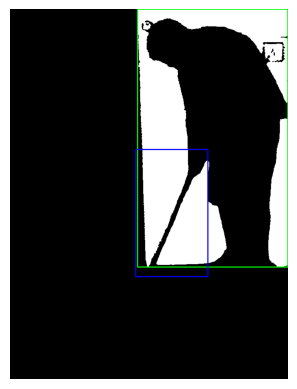

In [10]:
# Display the resulting image using matplotlib
plt.imshow(golf_bbox)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

### minArea Polygon instead of minarearect

In [11]:
count = 0
for contour in contours:
    # Find the convex hull around a single contour 
    hull = cv2.convexHull(contour)

    # Draw the convex hull
    polygon = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [hull], 0, (0, 255, 0), 4)

    # Display the result
    # cv2.imshow('Image with min area rectangle and convex hull', polygon)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    cv2.imwrite(f"{dir_path}/bounding_polygon_{count}.png", polygon)

    count += 1

In [12]:
polygon.shape

(960, 720, 3)

In [13]:
np.unique(polygon)

array([  0, 255], dtype=uint8)

### Find Contour bbox with max overlap with golf bbox

In [14]:
from utils import find_max_overlap

In [15]:
golf_bbox = [top_left_x, top_left_y, top_left_x+crop_width, top_left_y+crop_height]

max_overlap_box, max_iou = find_max_overlap(box_points, golf_bbox)
print("Bounding box with maximum overlap:", max_overlap_box)
print("Maximum IoU value:", max_iou)

Bounding box with maximum overlap: [[330   0]
 [719   0]
 [719 669]
 [330 669]]
Maximum IoU value: 0.20833880671518273


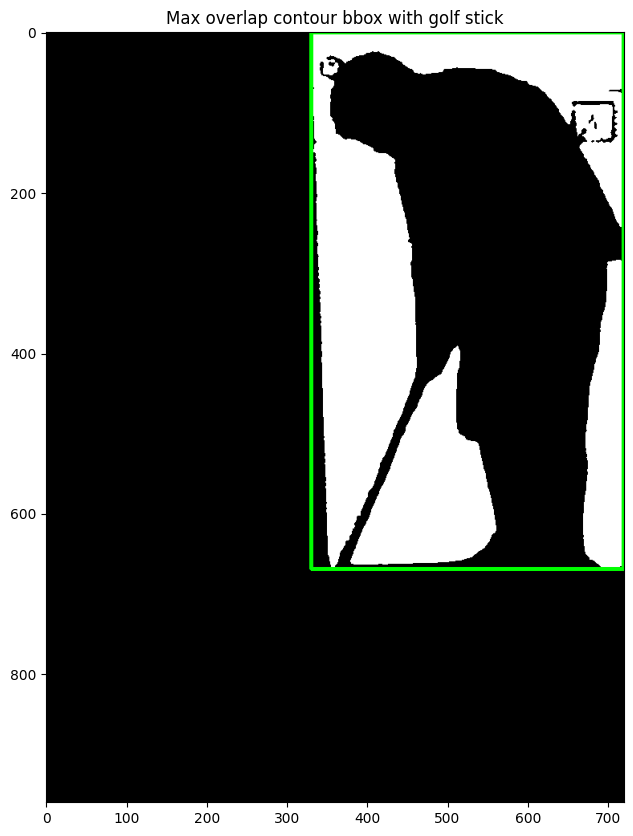

In [16]:
if max_overlap_box is not None:
    # draw the bounding box with max overlap
    bounding_box = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [max_overlap_box], 0, (0, 255, 0), 4)  # Color set to green (BGR format)

    plt.figure(figsize=(20, 10))
    plt.title("Max overlap contour bbox with golf stick")
    plt.imshow(bounding_box)
    plt.show()


In [17]:
plt.imsave(f"{dir_path}/max_overlap_bbox.png", bounding_box)

### Calculate the angle of left vertical edge with image vertical axis

In [18]:
from utils1 import calculate_vertical_edge_angle

if max_overlap_box is not None:
    angle_degrees = calculate_vertical_edge_angle(max_overlap_box)
    print(angle_degrees)

Angle of the right vertical edge with the right edge of the image: 90.00 degrees
90.0


### Find the contour bbox that is closest to golf bbox 

### If door is to the left, take the right edge of cotour bbox, else take the left edge

In [19]:
bp = box_points[0]

In [20]:
import math 

def bbox_angle(bbox):
    # calculate the angle of the left vertical edge of bbox with vertical axis of image
    sorted_points = bbox[np.argsort(bbox[:, 1])]
    sorted_points = sorted_points[np.argsort(sorted_points[:, 0])]

    # Identify the top-right and bottom-right vertices
    # top-right: the point with maximum x-coordinate from the top two points
    # bottom-right: the point with maximum x-coordinate from the bottom two points
    top_two = sorted_points[:2]
    bottom_two = sorted_points[2:]

    top_right = top_two[np.argmax(top_two[:, 0])]
    bottom_right = bottom_two[np.argmax(bottom_two[:, 0])]

    # Calculate the differences in coordinates
    dy = bottom_right[1] - top_right[1]
    dx = bottom_right[0] - top_right[0]

    # Calculate the angle in radians
    angle_radians = math.atan2(dy, dx)

    # Convert the angle to degrees
    angle_degrees = math.degrees(angle_radians)

    # Since we need the angle with the vertical edge (y-axis), we take 90 degrees minus the calculated angle
    angle_with_vertical = 90 - angle_degrees

    print(f"Angle of the right vertical edge with the right edge of the image: {angle_with_vertical:.2f} degrees")

    return angle_with_vertical

In [21]:
angle = bbox_angle(bp)
angle

Angle of the right vertical edge with the right edge of the image: 90.00 degrees


90.0

In [22]:
90 - angle

0.0